# Graphics and tables

Graphics and tables for the paper.

## Setup

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from pathlib import Path

In [2]:
plt.style.use('science')

## Experiments

In [3]:
# Copied and pasted from Google Sheets
all_experiments = """2023-05-16-23-39-44





2023-05-16-23-39-44







2023-05-18-18-25-50





2023-05-18-18-25-50"""
all_experiments = all_experiments.split("\n")
all_experiments = [x for x in all_experiments if x != ""]
all_experiments = set(all_experiments)
all_experiments

{'2023-05-16-23-39-44', '2023-05-18-18-25-50'}

## Data loading

In [4]:
all_results = dict()
experiments = []

for item in Path("..").glob("data/experiments/*"):
    if item.is_dir() and item.name in all_experiments:
        for experiment in item.glob("*"):
            if experiment.is_dir():
                if (experiment / "results.jsonl").exists():
                    experiment_name = experiment.name
                    print(experiment_name)
                    experiments.append(experiment_name)
                    all_results[experiment_name] = []
                    with open(experiment / "results.jsonl", 'r') as f:
                        for line in f:
                            all_results[experiment_name].append(json.loads(line))

hatexplain_all-shap-tf_idf-2
hatexplain_all-lime-tf_idf-2
tweet_sentiment_extraction_all-shap-distilbert-2
tweet_sentiment_extraction_all-lime-distilbert-2


## Data checking

In [5]:
# Assert experiments are unique
assert len(experiments) == len(set(experiments))

# Assert we have all experiments
ground_truth_experiments = set()
for explainer in ["lime", "shap"]:
    ground_truth_experiments.add(f"hatexplain_all-{explainer}-tf_idf-2")
    ground_truth_experiments.add(f"tweet_sentiment_extraction_all-{explainer}-distilbert-2")
assert set(experiments) == ground_truth_experiments

## Plot graphics

In [6]:
def filter_results(results):
    """Filter the results.

    Remove the None and NaN values from the results.

    Args:
        results (list of float): Results to filter.
    
    Returns:
        list of float: Filtered results.
    """
    return [result for result in results \
        if result is not None and not np.isnan(result)]

In [7]:
for explainer in ["lime", "shap"]:
    print(f"    \"hatexplain_all-{explainer}-tf_idf-2\": 14,")
    print(f"    \"tweet_sentiment_extraction_all-{explainer}-distilbert-2\": 14,")

    "hatexplain_all-lime-tf_idf-2": 14,
    "tweet_sentiment_extraction_all-lime-distilbert-2": 14,
    "hatexplain_all-shap-tf_idf-2": 14,
    "tweet_sentiment_extraction_all-shap-distilbert-2": 14,


In [8]:
# Manually copied and pasted from the above print statement
# Manually set the numbers
good_result_map = {
    "hatexplain_all-lime-tf_idf-2": 9,
    "tweet_sentiment_extraction_all-lime-distilbert-2": 11,
    "hatexplain_all-shap-tf_idf-2": 9,
    "tweet_sentiment_extraction_all-shap-distilbert-2": 11,
}

In [9]:
def plot_graphic(name, results, ax):
    results = sorted(results, key=lambda x: x['weight'])
    results = results[1:]  # Remove the first result (cross-entropy weight = 0)
    weights = [result['weight'] for result in results]

    performance_metric = "accuracy"
    explainability_metric = "alternative_auprc"
    x = []
    y = []
    for result in results:
        x.append(result['performance'][performance_metric])
        y.append(
            np.mean(
                filter_results(result['explainability'][explainability_metric])
            )
        )

    sns.scatterplot(
        x="Accuracy",
        y="AUPRC",
        data=pd.DataFrame({
            "Accuracy": x,
            "AUPRC": y,
        }),
        hue=weights,
        ax=ax,
    )

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")

    good_result_index = good_result_map[name]
    x = x[good_result_index]
    y = y[good_result_index]
    ax.scatter(x, y)
    
    # norm = plt.Normalize(0, max(weights))
    # cmap = sns.cubehelix_palette(as_cmap=True)
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # fig.colorbar(
    #     sm,
    #     orientation="vertical",
    #     label="Cross-entropy weight ($w_1$)",
    # )
    # plt.savefig("accuracy_auprc.pdf", dpi=300, bbox_inches="tight")    

In [10]:
def get_table_line(experiment_name, results):
    results = sorted(results, key=lambda x: x['weight'])
    results = results[1:]  # Remove the first result (cross-entropy weight = 0)
    bad_result = results[-1]
    good_result = results[good_result_map[experiment_name]]
    # x = good_result['performance']['accuracy']
    # y = np.mean(filter_results(good_result['explainability']['alternative_auprc']))
    weight = good_result['weight']

    good_accuracy = good_result['performance']['accuracy']
    bad_accuracy = bad_result['performance']['accuracy']
    accuracy_gain = (good_accuracy - bad_accuracy) * 100

    good_auprc = np.mean(filter_results(good_result['explainability']['alternative_auprc']))
    bad_auprc = np.mean(filter_results(bad_result['explainability']['alternative_auprc']))
    auprc_gain = (good_auprc - bad_auprc) * 100
    auprc_gain_relative = (good_auprc - bad_auprc) / bad_auprc * 100

    good_sufficiency = np.mean(filter_results(good_result['explainability']['sufficiency_aopc']))
    bad_sufficiency = np.mean(filter_results(bad_result['explainability']['sufficiency_aopc']))
    # sufficiency_gain = (good_sufficiency - bad_sufficiency) * 100

    good_random_sufficiency = np.mean(filter_results(good_result['explainability']['random_sufficiency_aopc']))
    bad_random_sufficiency = np.mean(filter_results(bad_result['explainability']['random_sufficiency_aopc']))
    # random_sufficiency_gain = (good_random_sufficiency - bad_random_sufficiency) * 100

    delta_good_sufficiency = -good_sufficiency
    delta_bad_sufficiency = -bad_sufficiency
    sufficiency_gain = (delta_good_sufficiency - delta_bad_sufficiency)

    good_comprehensiveness = np.mean(filter_results(good_result['explainability']['comprehensiveness_aopc']))
    bad_comprehensiveness = np.mean(filter_results(bad_result['explainability']['comprehensiveness_aopc']))
    # comprehensiveness_gain = (good_comprehensiveness - bad_comprehensiveness) * 100

    good_random_comprehensiveness = np.mean(filter_results(good_result['explainability']['random_comprehensiveness_aopc']))
    bad_random_comprehensiveness = np.mean(filter_results(bad_result['explainability']['random_comprehensiveness_aopc']))
    # random_comprehensiveness_gain = (good_random_comprehensiveness - bad_random_comprehensiveness) * 100

    delta_good_comprehensiveness = good_comprehensiveness #  - good_random_comprehensiveness
    delta_bad_comprehensiveness = bad_comprehensiveness #  - bad_random_comprehensiveness
    comprehensiveness_gain = (delta_good_comprehensiveness - delta_bad_comprehensiveness)
    
    return [experiment_name, weight, accuracy_gain, auprc_gain, auprc_gain_relative, sufficiency_gain, comprehensiveness_gain]

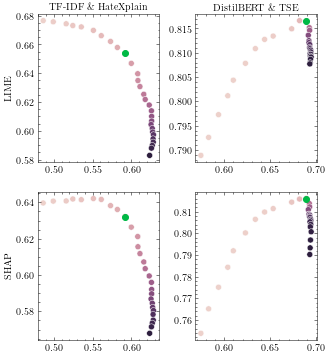

In [11]:
table_all = []
fig = plt.figure(figsize=(5, 6))

explainers = ["lime", "shap"]
grid = np.array([
    [
        f"hatexplain_all-{explainer}-tf_idf-2",
        f"tweet_sentiment_extraction_all-{explainer}-distilbert-2",
    ] for explainer in explainers
])
axes = fig.subplot_mosaic(grid)

for key in axes.keys():
    plot_graphic(key, all_results[key], axes[key])
    line = get_table_line(key, all_results[key])
    table_all.append(line)

for key in grid[:, 0]:
    axes[key].set_ylabel({
        "lime": "LIME",
        "shap": "SHAP",
    }[key.split("-")[1]])

for key in grid[0]:
    axes[key].set_xlabel({
        "hatexplain_all": "TF-IDF \& HateXplain",
        "tweet_sentiment_extraction_all": "DistilBERT \& TSE",
    }[key.split("-")[0]])
    axes[key].xaxis.set_label_position('top')

plt.subplots_adjust(wspace=0.3)
plt.savefig(
    f"three_classes_graphic.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
plt.close()

In [12]:
table_all_df = pd.DataFrame(table_all)
table_all_df.columns = ["Model", "w1", "Acc.", "AUPRC", "AUPRC (rel.)", "Suff.", "Comp."]
table_all_df = table_all_df.set_index("Model", inplace=False)
table_all_df.index = [name.replace("-2", "").replace("tweet_sentiment_extraction", "tse")
                      for name in table_all_df.index]
indices = []
explainers = ["lime", "shap"]
[indices.append(f"hatexplain_all-{explainer}-tf_idf") for explainer in explainers]
[indices.append(f"tse_all-{explainer}-distilbert") for explainer in explainers]
table_all_df = table_all_df.loc[indices]

table_all_df['w1'] = table_all_df['w1'].apply(
    lambda x: f"{round(x, 2):.2f}" if round(x, 2) != 0.0 else f"{round(x, 3):.3f}"
)
other_columns = ["Acc.", "AUPRC", "AUPRC (rel.)", "Suff.", "Comp."]
table_all_df[other_columns] = table_all_df[other_columns].applymap(
    lambda x: f"{round(x, 2):.2f}"
)
latex = table_all_df.to_latex()
latex = latex.replace("{lllllll}", "{lr|ccccc}")
latex = latex.replace(r"\toprule", r"\hline")
latex = latex.replace(r"\midrule", r"\hline")
latex = latex.replace(r"\bottomrule", r"\hline")
latex = latex.replace(
    r"{} &    w1 &   Acc. & AUPRC & AUPRC (rel.) &  Suff. &  Comp. \\",
    r"\textbf{Model}           & \textbf{$w_1$} & \textbf{Acc. \%} & \textbf{AUPRC \%} & \textbf{AUPRC rel. \%} & \textbf{Suff.} & \textbf{Comp.} \\"
)
print(latex)

\begin{tabular}{lr|ccccc}
\hline
\textbf{Model}           & \textbf{$w_1$} & \textbf{Acc. \%} & \textbf{AUPRC \%} & \textbf{AUPRC rel. \%} & \textbf{Suff.} & \textbf{Comp.} \\
\hline
hatexplain\_all-lime-tf\_idf &  0.19 &  -3.17 &  7.09 &        12.16 &  -0.00 &  -0.06 \\
hatexplain\_all-shap-tf\_idf &  0.19 &  -3.17 &  6.42 &        11.30 &  -0.00 &  -0.06 \\
tse\_all-lime-distilbert    &  0.25 &  -0.37 &  0.88 &         1.09 &   0.01 &  -0.01 \\
tse\_all-shap-distilbert    &  0.25 &  -0.37 &  2.58 &         3.26 &  -0.02 &  -0.00 \\
\hline
\end{tabular}

